In [1]:
import qiskit
from qiskit import QuantumCircuit, assemble, Aer
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.circuit.library import XXPlusYYGate
from qiskit import *
from qiskit import transpile
from itertools import combinations as combs
import scipy
from scipy import *
from IPython.display import clear_output
import matplotlib.pyplot as plt
from qiskit.algorithms.optimizers import SPSA
sim = Aer.get_backend('qasm_simulator')
import numpy as np
import random

In [5]:
#QAOA Implementation

#Scoring function for an assignment of k-vertices 
def score_k(k,edges):
    sum1=0
    for edge in edges:
        sum1 += int(k[edge[0]])|int(k[edge[1]])
    return sum1

#Returns expected score for a probability distribution of assignments of k-vertices 
def scorer(counts,edges):
    tot_score = 0
    for k in counts.keys():
        scr=score_k(k,edges)
        tot_score += counts[k]/sum(counts.values())*scr
    return -tot_score
                    
#Evolution of the problem hamiltonian
def pH(alpha,qc,edges):
    for v_i,v_j in edges:
        qc.rz(-alpha/4,v_i)
        qc.rz(-alpha/4,v_j)
        qc.cx(v_i,v_j)
        qc.rz(-alpha/4,v_j)
        qc.cx(v_i,v_j)
        
#Evolution of the mixer hamiltonian
def mH(beta,qc):
    for v_i,v_j in list(combs([x for x in range(qc.num_qubits)],2)):
        qc.append(XXPlusYYGate(beta),[v_i,v_j])

#Scoring function for p layers of pH and mH
def hamiltonian_evolution_score(alpha_beta_list,args):
    edges = args[0]
    n = args[1]
    init_state = args[2]
    
    assert(len(init_state) <= n)
    global qc
    qc = QuantumCircuit(n,n)
    for i in init_state:
        qc.x(i)
    alpha_list = alpha_beta_list[:len(alpha_beta_list)//2]
    beta_list = alpha_beta_list[len(alpha_beta_list)//2:]
    for a,b in zip(alpha_list,beta_list):
        pH(a,qc,edges)
        mH(b,qc)
    qc.measure([x for x in range(qc.num_qubits)],[x for x in range(qc.num_qubits)])
    counts = execute(qc,sim,shots=1000).result().get_counts(qc)
    score = scorer(counts,edges)
    return score

info = []

#Prints graph for iterations of the minimizer
def callback(x):
    info.append(hamiltonian_evolution_score(x,args=[edges,n,init_state]))
    plt.plot(info)
    plt.show()
    clear_output(wait=True)

#Main function – Runs classical optimizer over iterations of hamiltonian evolution with constant hamming weight
def solver(edges,alpha_list,beta_list,n,init_state):
    a_b_new = scipy.optimize.minimize(hamiltonian_evolution_score,alpha_list+beta_list,args=[edges,n,init_state],callback=callback,method='Nelder-Mead')
    return a_b_new
     

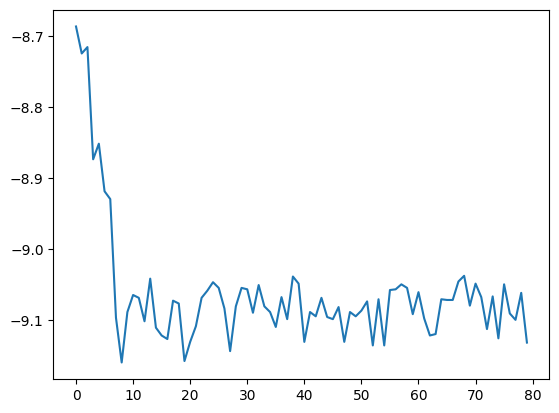

In [ ]:
global circ, edges
clear_output(wait=True)
info = []

#Sample implementation of initiliazing graph and running QAOA
n = 8
k = 2
p = 2
init_state = [1,4]
edges = [[0, 3],
 [0, 5],
 [0, 7],
 [1, 2],
 [1, 4],
 [1, 6],
 [2, 4],
 [2, 5],
 [2, 6],
 [2, 7],
 [3, 5],
 [3, 6],
 [3, 7],
 [4, 5],
 [4, 6],
 [4, 7],
 [5, 6],
 [5, 7],
 [6, 7]]

alpha_list = [0.68172723,3.11384796]
beta_list = [5.03486914,0.91427824]
opt_sol = 12

res = solver(edges,alpha_list,beta_list,n,init_state)

alpha_beta_opt = res.x

print(alpha_beta_opt)
print(hamiltonian_evolution_score(alpha_beta_opt,args=[edges,n,init_state]))
print(hamiltonian_evolution_score(alpha_beta_opt,args=[edges,n,init_state])/opt_sol)
print(init_state)
plt.plot(info)